# Spatial Correlation Matrix to AOA

This repo aims to learn the AOA of LoRa beacons from Spatial Correlation Matrix, R. Here is the nice article how support vector method (e.g, SVR) can also be used for regression.

https://www.saedsayad.com/support_vector_machine_reg.htm

In [1]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## Preparation
Create dataset for training and testing from Rosbag recorded .csv file named as 'deg_(theta).csv'. Useful features lie in field 1, 2, 3, 6, 7, and 11 of the spatial correlation matrix, R.

In [2]:
data_dir = 'data_0106'
aoa_dict = {}
#fields_lst = ['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [74]:
aoa_dict[-20][50:100]

,field.data0,field.data1,field.data2,field.data3,field.data5,field.data6,field.data7,field.data10,field.data11,field.data15,theta
50,2.533022e-03,3.425571e-02,-4.189927e-03,-2.346630e-02,0.482534,-5.037950e-02,-3.043928e-01,0.094900,0.190915,0.483402,-0.349066
51,2.530857e-03,3.425596e-02,-4.152296e-03,-2.358478e-02,0.482617,-5.187337e-02,-3.097905e-01,0.095891,0.190789,0.482488,-0.349066
52,2.587822e-08,2.261392e-08,1.164845e-08,6.566322e-08,0.000005,-1.503260e-07,1.522508e-07,0.000003,0.000002,0.000009,-0.349066
53,2.594465e-08,2.062994e-08,9.365227e-09,6.582155e-08,0.000005,-1.504653e-07,1.130049e-07,0.000003,0.000002,0.000009,-0.349066
54,2.615032e-08,1.875715e-08,1.204342e-08,7.061064e-08,0.000005,-1.527164e-07,1.062455e-07,0.000003,0.000002,0.000009,-0.349066
55,2.616157e-08,2.298685e-08,1.124364e-08,6.748628e-08,0.000005,-1.497422e-07,8.789468e-08,0.000003,0.000002,0.000009,-0.349066
56,2.621828e-08,2.369282e-08,1.199541e-08,6.690321e-08,0.000005,-1.245373e-07,1.321570e-07,0.000003,0.000002,0.000009,-0.349066
57,2.627745e-08,2.075140e-08,1.374589e-08,6.696943e-08,0.000005,-1.497532e-07,3.797863e-08,0.000003,0.000002,0.000009,-0.349066
58,2.591462e-08,2.004420e-08,1.306083e-08,7.264624e-08,0.000005,-1.052315e-07,1.710216e-07,0.000003,0.000002,0.000009,-0.349066
59,2.617951e-08,2.092090e-08,1.323987e-08,6.872720e-08,0.000005,-1.459726e-07,1.179671e-07,0.000003,0.000002,0.000009,-0.349066


In [4]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[-20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field.data0   475 non-null    float64
 1   field.data1   475 non-null    float64
 2   field.data2   475 non-null    float64
 3   field.data3   475 non-null    float64
 4   field.data5   475 non-null    float64
 5   field.data6   475 non-null    float64
 6   field.data7   475 non-null    float64
 7   field.data10  475 non-null    float64
 8   field.data11  475 non-null    float64
 9   field.data15  475 non-null    float64
dtypes: float64(10)
memory usage: 37.2 KB


In [5]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
# Show detection of LoRa beacon when Rjk is significant
aoa_dict[-50][abs(aoa_dict[-20]['field.data1']) > 1e-04]

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,field.data0,field.data1,field.data2,field.data3,field.data5,field.data6,field.data7,field.data10,field.data11,field.data15,theta
28,2.620505e-08,2.658627e-08,1.124060e-08,7.382095e-08,0.000005,-1.587623e-07,6.139996e-08,0.000003,0.000002,0.000009,-0.872665
29,2.629033e-08,1.975904e-08,1.491344e-08,7.068575e-08,0.000005,-1.245820e-07,1.058091e-07,0.000003,0.000002,0.000009,-0.872665
30,2.606527e-08,1.998568e-08,1.511669e-08,7.651189e-08,0.000005,-1.347338e-07,8.508809e-08,0.000003,0.000002,0.000009,-0.872665
31,2.558553e-03,3.169357e-02,-9.566627e-03,-3.251502e-02,0.492117,1.552081e-02,-3.222316e-01,0.258088,0.257033,0.501299,-0.872665
32,2.544869e-03,3.116821e-02,-9.915808e-03,-3.217950e-02,0.488423,1.645199e-02,-3.087187e-01,0.256796,0.262564,0.498412,-0.872665
...,...,...,...,...,...,...,...,...,...,...,...
239,2.630287e-08,2.442835e-08,1.635955e-08,7.017881e-08,0.000005,-1.364530e-07,1.669141e-07,0.000003,0.000002,0.000009,-0.872665
240,2.530813e-03,2.979768e-02,-9.315724e-03,-3.126066e-02,0.473738,4.117281e-02,-2.636383e-01,0.246982,0.263525,0.494307,-0.872665
241,2.523635e-03,2.989854e-02,-9.494187e-03,-3.145699e-02,0.473001,3.433172e-02,-2.741461e-01,0.245303,0.259855,0.492466,-0.872665
242,2.530599e-03,2.982917e-02,-9.208411e-03,-3.124801e-02,0.474528,4.255921e-02,-2.639352e-01,0.246926,0.262332,0.494006,-0.872665


In [7]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) < 1e-04].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) >= 1e-04].index)

In [8]:
aoa_sig[-20]

,field.data0,field.data1,field.data2,field.data3,field.data5,field.data6,field.data7,field.data10,field.data11,field.data15,theta
28,0.002155,0.029120,-0.004747,-0.019659,0.411517,-0.054915,-0.247967,0.094678,0.183121,0.413993,-0.349066
29,0.002550,0.034585,-0.005208,-0.023544,0.489468,-0.063600,-0.304891,0.106903,0.209142,0.489873,-0.349066
30,0.002544,0.034479,-0.005386,-0.023654,0.488217,-0.065085,-0.305028,0.111913,0.213947,0.490159,-0.349066
31,0.002533,0.034324,-0.005165,-0.023151,0.485739,-0.061950,-0.298076,0.116797,0.217502,0.487732,-0.349066
32,0.002542,0.034406,-0.005010,-0.023406,0.485884,-0.059444,-0.300179,0.106784,0.207640,0.488254,-0.349066
...,...,...,...,...,...,...,...,...,...,...,...
466,0.002544,0.034573,-0.004444,-0.022177,0.488923,-0.057155,-0.294293,0.165328,0.254965,0.493443,-0.349066
467,0.002546,0.034593,-0.004461,-0.022479,0.490035,-0.057552,-0.298650,0.160104,0.250444,0.494245,-0.349066
468,0.002513,0.034138,-0.003922,-0.021809,0.483212,-0.048597,-0.287142,0.157571,0.245524,0.488032,-0.349066
469,0.002550,0.034597,-0.004306,-0.022594,0.489604,-0.055679,-0.300087,0.151765,0.243059,0.493943,-0.349066


In [9]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[-60], aoa_sig[-50], aoa_sig[-40], aoa_sig[-30], aoa_sig[-20], aoa_sig[-10], aoa_sig[0], aoa_sig[10], aoa_sig[20], aoa_sig[30], aoa_sig[40], aoa_sig[50], aoa_sig[60]], ignore_index=True)
Xaoa['theta'].value_counts()

 0.872665    145
-0.349066    138
 1.047198    125
 0.698132    114
 0.349066    101
 0.174533     95
-1.047198     92
-0.174533     89
 0.000000     78
-0.872665     71
-0.698132     70
 0.523599     58
-0.523599     55
Name: theta, dtype: int64

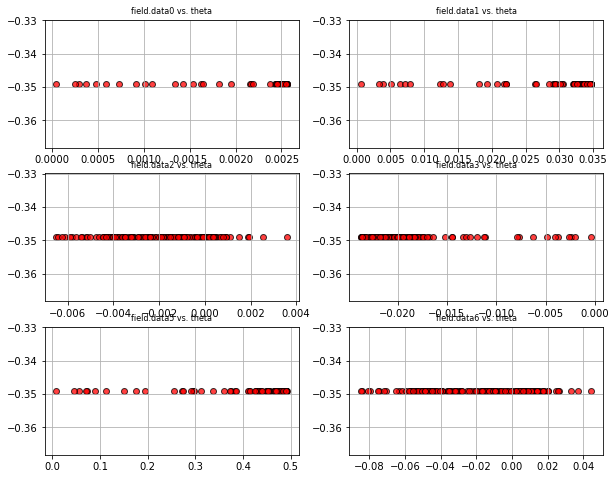

In [10]:
# Visualize data
fig,ax = plt.subplots(3,2,figsize=(10,8))
ax = ax.ravel()
visual_key = -20
for i in range(6):
    ax[i].scatter(aoa_sig[visual_key][aoa_sig[visual_key].columns[i]],aoa_sig[visual_key]['theta'],edgecolor='k',color='red',alpha=0.75)
    ax[i].set_title(f"{aoa_sig[visual_key].columns[i]} vs. theta",fontsize=8)
    ax[i].grid(True)
plt.show()

## Training
### SVR
Here is scikit-learn's SVR doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [11]:
X = Xaoa.drop('theta', axis=1)
y = Xaoa['theta']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
'''
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
'''

'\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.fit_transform(X_test)\n'

### Kernal arg: 'rbf' vs 'sigmoid' vs 'linear'

In [14]:
# Support vector regressor with Gaussian (Radial Basis Function) kernel
svr_1 = SVR(kernel='rbf',gamma='scale', C=2.0, epsilon=0.3)
svr_1.fit(X_train, y_train) 

SVR(C=2.0, epsilon=0.3)

In [15]:
svr_1.score(X_test,y_test)

0.6959371697788944

In [16]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_1.predict(X_test))))

RMSE for RBF kernelized SVR: 0.3600426004402304


In [17]:
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_1,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=SVR(C=2.0, epsilon=0.3),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5],
                         'epsilon': [0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='r2', verbose=1)

In [18]:
grid.best_estimator_

SVR(C=5)

In [19]:
svr_best=SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.3)
svr_best.fit(X_train, y_train)
svr_best.score(X_test, y_test)

0.7270535681588186

In [20]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_best.predict(X_test))))

RMSE for RBF kernelized SVR: 0.34112294594125253


In [21]:
low_bound = 150
high_bound = 200
pred_y = svr_best.predict(X_test[low_bound:high_bound])
print(pred_y)

[ 0.65943789 -0.22636149  0.31153206  0.04555796  0.50562388  1.18840473
  0.45573015  0.18041469  0.74751845 -1.46474358 -0.61640335  0.48882437
  0.94532206  0.19802699  0.73340332  0.21215678  0.1661514   0.41480652
  0.45097726  0.54908252 -0.48566544 -0.24196872  0.38909351  0.37070255
 -0.3398155   0.35455912 -0.61859184 -0.91784874 -0.86146114  0.20418396
  0.28281612 -0.65510966 -0.83345698 -0.55286648 -0.95629751  0.26888857
 -0.91764017  0.90671122 -0.26001927  0.17090222  0.46783755  0.45673088
  0.84520176  0.28467282  0.08392345 -0.06992128  0.07319477 -0.67990166
 -0.77812197  0.29583488]


In [22]:
y_test[low_bound:high_bound]
print(y_test.shape)

(247,)


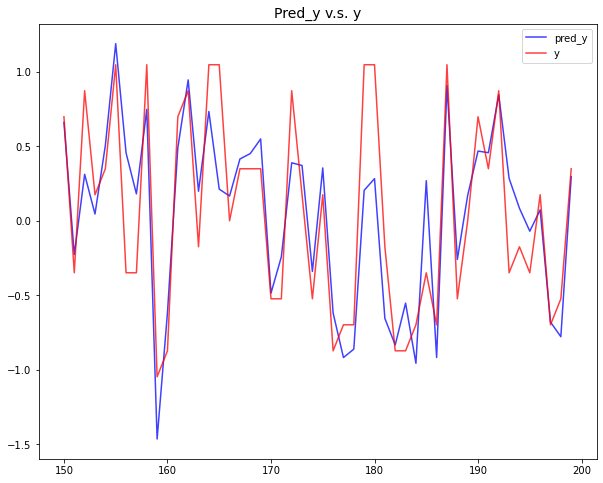

In [23]:
# Visualize data
fig2,ax2 = plt.subplots(1,1,figsize=(10,8))
ax2.plot([i for i in range(low_bound,high_bound)], list(pred_y), color='b', alpha=0.75, label='pred_y')
ax2.plot([i for i in range(low_bound,high_bound)], list(y_test.to_numpy()[low_bound:high_bound]), color='red', alpha=0.75, label='y')
ax2.set_title(f"Pred_y v.s. y",fontsize=14)
ax2.grid(False)
ax2.legend(loc='best')
plt.show()

### MLP ANN

In [24]:
le = LabelEncoder()

In [25]:
sc = StandardScaler()

In [26]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_test_std

array([[-1.68365629, -1.53383171,  0.80051723, ..., -0.8890124 ,
        -0.94058144, -1.56878376],
       [ 0.80716688,  0.75257566, -1.68416192, ...,  0.84664444,
         0.92463649,  0.88731339],
       [-1.17459972, -1.57333376,  1.21937269, ..., -0.92026925,
        -0.74876525,  0.36918074],
       ...,
       [ 0.83964204,  1.18587644,  0.16399331, ..., -0.01694838,
         0.63764808,  0.82478446],
       [ 0.43737637,  0.77518153,  0.06709535, ..., -0.59570897,
         0.07994146,  0.36917862],
       [-0.15569263, -0.43136146, -0.19824806, ..., -0.70226741,
        -0.48417788, -1.00765717]])

In [27]:
y_train_std = le.fit_transform(y_train)
y_test_std = le.fit_transform(y_test)
y_test_std

array([ 6, 11,  3,  6, 12, 10,  8,  6,  1,  1,  4, 11,  2, 11, 11,  4,  7,
        4, 10,  4,  6,  4, 11, 12,  3, 11,  9, 12,  0,  0,  2, 10,  1,  4,
        8,  7,  6,  1, 11,  1, 10,  8,  5, 11,  2,  3,  7, 10,  4, 10,  8,
       11,  4,  0,  4, 12,  0,  4, 10,  8, 12,  7, 10,  8,  8,  8, 10, 11,
        0, 11, 10, 11,  0,  8, 12,  5, 11,  3, 11,  6, 10,  8,  0,  6,  0,
        9, 11,  0,  7, 10,  7, 12,  0,  4, 11,  2,  4,  9,  6, 12,  7,  2,
       11,  7,  0,  7,  7,  6, 11, 10,  1,  2, 12,  0,  7,  4,  8,  0,  0,
        5,  9,  1,  6, 12, 12,  6, 10,  4,  8,  6,  7, 12,  5,  5,  9,  4,
       12,  6,  6,  8, 10,  4,  4,  9, 12,  8,  7, 10,  5,  3, 10,  4, 11,
        7,  8, 12,  4,  4, 12,  0,  1, 10, 11,  5, 12, 12,  6,  8,  8,  8,
        3,  3, 11,  7,  3,  7,  1,  2,  2, 12, 12,  5,  1,  1,  2,  4,  2,
       12,  3,  6, 10,  8, 11,  4,  5,  4,  7,  2,  3,  8,  2,  5, 11,  1,
        6,  4,  4,  3,  2, 12, 11,  6,  8,  4,  7, 11,  2,  2,  8,  5, 12,
        4,  4, 11,  4,  6

In [28]:
mlpr = MLPRegressor(hidden_layer_sizes=4, random_state=1, max_iter=500)
mlpr.fit(X_train_std, y_train_std)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=4, max_iter=500, random_state=1)

## Autoencoder + FC
### Vanilla Autoencoder

In [29]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

In [30]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
print(X_train_np.shape)
print(y_train_np.shape)

(984, 10)
(984,)


In [31]:
mmsc = MinMaxScaler()
mmsc.fit(X_train_np)
X_train_np_std = mmsc.transform(X_train_np.astype("float32"))
X_test_np_std = mmsc.transform(X_test_np.astype("float32"))

In [32]:
maxX = np.max(X_train_np)
minX = np.min(X_train_np)
maxy = np.max(y_train_np)
miny = np.min(y_train_np)
#X_train_np_std = (X_train_np.astype("float32") - minX)/(maxX-minX)
#X_test_np_std = (X_test_np.astype("float32") - minX)/(maxX-minX)
y_train_np_std = (y_train_np.astype("float32") - miny)/(maxy-miny)
y_test_np_std = (y_test_np.astype("float32") - miny)/(maxy-miny)

In [33]:
y_test_np_std.shape

(247,)

In [34]:
input_size = num_fields#6
hidden_size = 6
output_size = num_fields#6

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

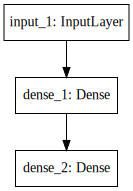

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#plot_model(autoencoder, to_file='vanilla_autoencoder.png', show_shapes=True)
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [36]:
epochs = 100
batch_size = 50

history = autoencoder.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_np_std, X_test_np_std))



Train on 984 samples, validate on 247 samples
Epoch 1/100
984/984 [==============================] - 0s 434us/step - loss: 0.1000 - val_loss: 0.0959
Epoch 2/100
984/984 [==============================] - 0s 70us/step - loss: 0.0969 - val_loss: 0.0929
Epoch 3/100
984/984 [==============================] - 0s 29us/step - loss: 0.0935 - val_loss: 0.0891
Epoch 4/100
984/984 [==============================] - 0s 32us/step - loss: 0.0894 - val_loss: 0.0847
Epoch 5/100
984/984 [==============================] - 0s 46us/step - loss: 0.0849 - val_loss: 0.0800
Epoch 6/100
984/984 [==============================] - 0s 31us/step - loss: 0.0799 - val_loss: 0.0748
Epoch 7/100
984/984 [==============================] - 0s 44us/step - loss: 0.0743 - val_loss: 0.0692
Epoch 8/100
984/984 [==============================] - 0s 54us/step - loss: 0.0685 - val_loss: 0.0633
Epoch 9/100
984/984 [==============================] - 0s 37us/step - loss: 0.0626 - val_loss: 0.0574
Epoch 10/100
984/984 [===========

984/984 [==============================] - 0s 56us/step - loss: 0.0086 - val_loss: 0.0082
Epoch 77/100
984/984 [==============================] - 0s 85us/step - loss: 0.0085 - val_loss: 0.0081
Epoch 78/100
984/984 [==============================] - 0s 51us/step - loss: 0.0084 - val_loss: 0.0080
Epoch 79/100
984/984 [==============================] - 0s 39us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 80/100
984/984 [==============================] - 0s 39us/step - loss: 0.0082 - val_loss: 0.0078
Epoch 81/100
984/984 [==============================] - 0s 50us/step - loss: 0.0081 - val_loss: 0.0077
Epoch 82/100
984/984 [==============================] - 0s 46us/step - loss: 0.0080 - val_loss: 0.0077
Epoch 83/100
984/984 [==============================] - 0s 48us/step - loss: 0.0079 - val_loss: 0.0076
Epoch 84/100
984/984 [==============================] - 0s 71us/step - loss: 0.0078 - val_loss: 0.0075
Epoch 85/100
984/984 [==============================] - 0s 49us/step - loss: 0.0077 - 

In [37]:
pred_X_test_np_std = autoencoder.predict(X_test_np_std)

In [38]:
pred_X_test_np_std.shape

(247, 10)

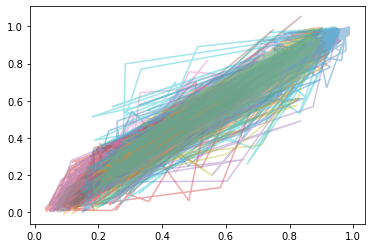

In [39]:
plt.plot(pred_X_test_np_std, X_test_np_std, alpha=.4)

dict_keys(['val_loss', 'loss'])


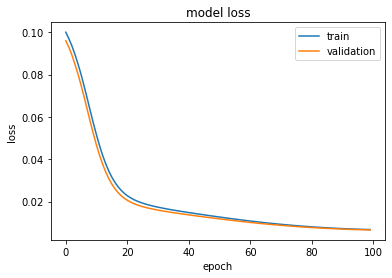

In [40]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
# Extract only the encoder model (discard the decoder)
encoder = Model(inputs=x, outputs=h)
#encoder.save("encoder.h5")
#plot_model(encoder, to_file='encoder.png', show_shapes=True)

### Multilayer Autoencoder

In [42]:
input_size = num_fields#6
h1_size = 6
h_size = 4
h2_size = 6
output_size = num_fields#6

x = Input(shape=(input_size,))
h1 = Dense(h1_size, activation='relu')(x)
h = Dense(h_size, activation='relu')(h1)
h2 = Dense(h2_size, activation='relu')(h)
r = Dense(output_size, activation='sigmoid')(h2)

autoencoder = Model(inputs=x, outputs=r)
for layer in autoencoder.layers:
    print(layer.output_shape)
autoencoder.compile(optimizer='adam', loss='mse')

(None, 10)
(None, 6)
(None, 4)
(None, 6)
(None, 10)


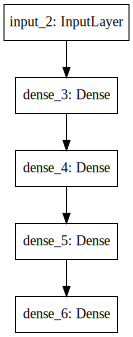

In [43]:
#plot_model(autoencoder, to_file='mlp_autoencoder.png', show_shapes=True)
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [44]:
epochs = 100
batch_size = 50

history = autoencoder.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, validation_data=(X_test_np_std, X_test_np_std))

Train on 984 samples, validate on 247 samples
Epoch 1/100
984/984 [==============================] - 1s 575us/step - loss: 0.1013 - val_loss: 0.0979
Epoch 2/100
984/984 [==============================] - 0s 78us/step - loss: 0.0997 - val_loss: 0.0964
Epoch 3/100
984/984 [==============================] - 0s 68us/step - loss: 0.0981 - val_loss: 0.0949
Epoch 4/100
984/984 [==============================] - 0s 147us/step - loss: 0.0965 - val_loss: 0.0931
Epoch 5/100
984/984 [==============================] - 0s 69us/step - loss: 0.0945 - val_loss: 0.0911
Epoch 6/100
984/984 [==============================] - 0s 77us/step - loss: 0.0923 - val_loss: 0.0888
Epoch 7/100
984/984 [==============================] - 0s 78us/step - loss: 0.0895 - val_loss: 0.0857
Epoch 8/100
984/984 [==============================] - 0s 57us/step - loss: 0.0861 - val_loss: 0.0818
Epoch 9/100
984/984 [==============================] - 0s 55us/step - loss: 0.0815 - val_loss: 0.0769
Epoch 10/100
984/984 [============

984/984 [==============================] - 0s 66us/step - loss: 0.0120 - val_loss: 0.0117
Epoch 81/100
984/984 [==============================] - 0s 56us/step - loss: 0.0120 - val_loss: 0.0116
Epoch 82/100
984/984 [==============================] - 0s 45us/step - loss: 0.0119 - val_loss: 0.0115
Epoch 83/100
984/984 [==============================] - 0s 51us/step - loss: 0.0118 - val_loss: 0.0115
Epoch 84/100
984/984 [==============================] - 0s 64us/step - loss: 0.0117 - val_loss: 0.0114
Epoch 85/100
984/984 [==============================] - 0s 64us/step - loss: 0.0117 - val_loss: 0.0113
Epoch 86/100
984/984 [==============================] - 0s 67us/step - loss: 0.0116 - val_loss: 0.0113
Epoch 87/100
984/984 [==============================] - 0s 84us/step - loss: 0.0116 - val_loss: 0.0112
Epoch 88/100
984/984 [==============================] - 0s 41us/step - loss: 0.0115 - val_loss: 0.0112
Epoch 89/100
984/984 [==============================] - 0s 39us/step - loss: 0.0114 - 

dict_keys(['val_loss', 'loss'])


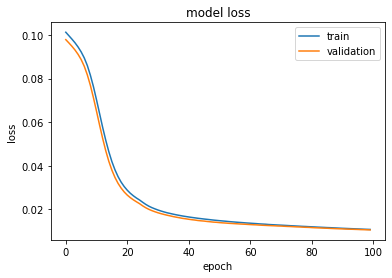

In [45]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Multitask Autoencoder!

In [46]:
input_size = num_fields#6
h1_size = 6
h_size = 4
h2_size = 6
output_size = num_fields#6

X_zero_np_std = np.zeros(X_train_np_std.shape)
X_zero_np_std.shape

(984, 10)

In [47]:
# Extract only encoder part
encoder = Model(inputs=x, outputs=h)

In [48]:
# Extract encoder + multitask-decoder
ae_dict = {}

for key in aoa_dict.keys():
    val = []
    
    Xaoa_cp = Xaoa.copy(deep=True)
    Xaoa_cp.loc[Xaoa_cp['theta'] != key * math.pi / 180, 'theta'] = -100.0
    X_tmp = Xaoa_cp.drop('theta', axis=1)
    # Make Autoencoder label <y_tmp> all zeros if in unmatched subregion
    for column in Xaoa_cp.columns[:-1]:
        Xaoa_cp.loc[Xaoa_cp['theta'] == -100, column] = 0
    y_tmp = Xaoa_cp.drop('theta', axis=1)
    
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)
    val.extend([X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp])
    
    decoder_h2 = Dense(h2_size, activation='relu')(h)
    decoder_r = Dense(output_size, activation='sigmoid')(decoder_h2)
    ae = Model(inputs=x, outputs=decoder_r)
    ae.compile(optimizer='adam', loss='mse')
    val.append(ae)
    
    ae_dict[key] = val
    
ae_dict[-60][0][ae_dict[-60][0]['field.data0'] != 0]

,field.data0,field.data1,field.data2,field.data3,field.data5,field.data6,field.data7,field.data10,field.data11,field.data15
1069,0.002483,0.029175,-0.012632,-0.034125,0.481507,-0.047488,-0.372331,0.142279,0.197039,0.488223
898,0.002485,0.029531,-0.013265,-0.032707,0.479469,-0.066733,-0.313147,0.139611,0.232811,0.488893
425,0.001333,0.018066,-0.002411,-0.011976,0.255209,-0.031983,-0.159904,0.077776,0.126052,0.257780
1227,0.000231,0.000625,-0.002981,-0.003772,0.026543,0.013551,-0.019973,0.057429,0.039902,0.066027
811,0.000460,0.002585,-0.002820,-0.005298,0.026753,-0.014674,0.002972,0.017401,0.035584,0.151976
...,...,...,...,...,...,...,...,...,...,...
1044,0.002496,0.028408,-0.015465,-0.034557,0.484757,-0.088997,-0.391834,0.145365,0.216604,0.491323
1095,0.002517,0.028589,-0.013458,-0.034824,0.489161,-0.052367,-0.384488,0.136232,0.194535,0.495809
1130,0.002514,0.026564,-0.011586,-0.033930,0.475336,-0.089294,-0.416260,0.059656,0.147400,0.486636
860,0.002469,0.028936,-0.013485,-0.032460,0.474201,-0.078287,-0.303552,0.123958,0.226958,0.483957


In [49]:
for key in ae_dict.keys():
  for i in range(2):
    print(ae_dict[key][i].shape)
ae_dict[10][-2][ae_dict[10][-2]['field.data2'] == 0]

(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)
(984, 10)
(247, 10)


,field.data0,field.data1,field.data2,field.data3,field.data5,field.data6,field.data7,field.data10,field.data11,field.data15
549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
epochs = 10
batch_size = 20
'''
for key in ae_dict.keys():
    
    ae_dict[key][-1].fit(ae_dict[key][0], ae_dict[key][2], batch_size=batch_size, epochs=epochs, validation_data=(ae_dict[key][1], ae_dict[key][3]))
'''

'\nfor key in ae_dict.keys():\n    \n    ae_dict[key][-1].fit(ae_dict[key][0], ae_dict[key][2], batch_size=batch_size, epochs=epochs, validation_data=(ae_dict[key][1], ae_dict[key][3]))\n'

In [51]:
encode_X_test_np_std = encoder.predict(X_test_np_std)
encode_X_test_np_std.shape

(247, 4)

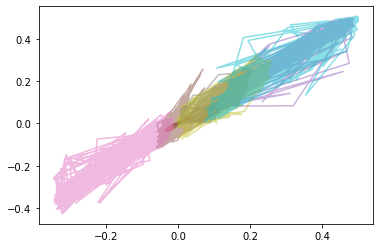

In [52]:
# Show autoencoder recovery
pred_X_test_np_std = autoencoder.predict(X_test_np_std)
pred_X_test_np = mmsc.inverse_transform(pred_X_test_np_std)

plt.plot(pred_X_test_np, X_test_np, alpha=.5)
plt.show()

### Classifier?!

In [53]:
aoa_classes = len(aoa_dict)
# Float -> LabelEncoder -> OneHotEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
integer_encoded = label_encoder.transform(y_train)
#print(integer_encoded)
# binary encode OR np_utils.to_categorical SAME!
'''
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_onehot = onehot_encoder.fit_transform(integer_encoded)
'''
y_onehot = np_utils.to_categorical(integer_encoded, num_classes=aoa_classes)
y_onehot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [54]:
# Classifier
classifier = Sequential()
classifier.add(Dense(9, input_dim=4, activation='relu'))
classifier.add(Dense(13, activation='softmax'))

for layer in classifier.layers:
    print(layer.output_shape)
# Compile model
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

(None, 9)
(None, 13)


In [55]:
# Prepare validation_data = (X_test, y_test)
yt_onehot = np_utils.to_categorical(label_encoder.transform(y_test), num_classes=aoa_classes)
encode_X_train_np_std = encoder.predict(X_train_np_std)
encode_X_test_np_std = encoder.predict(X_test_np_std)
encode_X_test_np_std.shape

(247, 4)

In [56]:
epochs = 100
batch_size = 50

history = classifier.fit(encode_X_train_np_std, y_onehot, batch_size=batch_size, epochs=epochs, validation_data=(encode_X_test_np_std, yt_onehot))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 984 samples, validate on 247 samples
Epoch 1/100
984/984 [==============================] - 1s 586us/step - loss: 2.7304 - categorical_accuracy: 0.0488 - val_loss: 2.6401 - val_categorical_accuracy: 0.0607
Epoch 2/100
984/984 [==============================] - 0s 116us/step - loss: 2.6505 - categorical_accuracy: 0.0772 - val_loss: 2.5791 - val_categorical_accuracy: 0.0688
Epoch 3/100
984/984 [==============================] - 0s 77us/step - loss: 2.5926 - categorical_accuracy: 0.0965 - val_loss: 2.5342 - val_categorical_accuracy: 0.1296
Epoch 4/100
984/984 [==============================] - 0s 103us/step - loss: 2.5471 - categorical_accuracy: 0.1677 - val_loss: 2.4997 - val_categorical_accuracy: 0.1903
Epoch 5/100
984/984 [==============================] - 0s 103us/step - loss: 2.5085 - categorical_accuracy: 0.1951 - val_loss: 2.4694 - val_categorical_accuracy: 0.1903
Epoch 6/100
984/

984/984 [==============================] - 0s 55us/step - loss: 1.9034 - categorical_accuracy: 0.3415 - val_loss: 1.8875 - val_categorical_accuracy: 0.3482
Epoch 48/100
984/984 [==============================] - 0s 141us/step - loss: 1.8958 - categorical_accuracy: 0.3425 - val_loss: 1.8792 - val_categorical_accuracy: 0.3563
Epoch 49/100
984/984 [==============================] - 0s 49us/step - loss: 1.8886 - categorical_accuracy: 0.3476 - val_loss: 1.8711 - val_categorical_accuracy: 0.3603
Epoch 50/100
984/984 [==============================] - 0s 46us/step - loss: 1.8817 - categorical_accuracy: 0.3496 - val_loss: 1.8633 - val_categorical_accuracy: 0.3644
Epoch 51/100
984/984 [==============================] - 0s 86us/step - loss: 1.8749 - categorical_accuracy: 0.3598 - val_loss: 1.8561 - val_categorical_accuracy: 0.3765
Epoch 52/100
984/984 [==============================] - 0s 159us/step - loss: 1.8683 - categorical_accuracy: 0.3547 - val_loss: 1.8494 - val_categorical_accuracy: 0.37

984/984 [==============================] - 0s 133us/step - loss: 1.7092 - categorical_accuracy: 0.4380 - val_loss: 1.6779 - val_categorical_accuracy: 0.4615
Epoch 96/100
984/984 [==============================] - 0s 107us/step - loss: 1.7068 - categorical_accuracy: 0.4431 - val_loss: 1.6751 - val_categorical_accuracy: 0.4494
Epoch 97/100
984/984 [==============================] - 0s 128us/step - loss: 1.7041 - categorical_accuracy: 0.4431 - val_loss: 1.6719 - val_categorical_accuracy: 0.4656
Epoch 98/100
984/984 [==============================] - 0s 82us/step - loss: 1.7025 - categorical_accuracy: 0.4451 - val_loss: 1.6711 - val_categorical_accuracy: 0.4656
Epoch 99/100
984/984 [==============================] - 0s 80us/step - loss: 1.6997 - categorical_accuracy: 0.4370 - val_loss: 1.6699 - val_categorical_accuracy: 0.4575
Epoch 100/100
984/984 [==============================] - 0s 86us/step - loss: 1.6980 - categorical_accuracy: 0.4482 - val_loss: 1.6666 - val_categorical_accuracy: 0.

{Encoded feature --> one-hot thetas} not working!

### SVR upon Encoded Features of R

In [57]:
svr_2 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.3)
svr_2.fit(encode_X_train_np_std, y_train) 

SVR(C=5.0, epsilon=0.3)

In [58]:
svr_2.score(encode_X_test_np_std, y_test)

0.5027411392922738

In [59]:
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_2,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(encode_X_train_np_std, y_train)
grid.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


SVR(C=5, epsilon=0.2)

In [60]:
svr_best2 = SVR(kernel='rbf', gamma='scale', C=5.0, epsilon=0.2)
svr_best2.fit(encode_X_train_np_std, y_train)
svr_best2.score(encode_X_test_np_std, y_test)

0.5035047059998201

In [61]:
print("RMSE for RBF kernelized SVR2:",np.sqrt(mean_squared_error(y_test, svr_best2.predict(encode_X_test_np_std))))

RMSE for RBF kernelized SVR2: 0.4600762250319149


### Regularized Autoencoder

In [66]:
input_size = num_fields#6
hidden_size = 6#5
output_size = num_fields#6

model = Sequential()
model.add(Dense(hidden_size, input_dim=input_size, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(output_size, activation='sigmoid'))

for layer in model.layers:
    print(layer.output_shape)
model.compile(optimizer='adam', loss='mse')
model.summary()

(None, 6)
(None, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_38 (Dense)             (None, 10)                70        
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


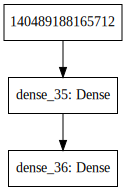

In [63]:
#plot_model(model, to_file='reg_autoencoder.png', show_shapes=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [64]:
epochs = 100
batch_size = 50

history = model.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, validation_data=(X_test_np_std, X_test_np_std))

Train on 984 samples, validate on 247 samples
Epoch 1/100
984/984 [==============================] - 1s 582us/step - loss: 0.1088 - val_loss: 0.1032
Epoch 2/100
984/984 [==============================] - 0s 57us/step - loss: 0.1025 - val_loss: 0.0977
Epoch 3/100
984/984 [==============================] - 0s 52us/step - loss: 0.0974 - val_loss: 0.0932
Epoch 4/100
984/984 [==============================] - 0s 67us/step - loss: 0.0933 - val_loss: 0.0894
Epoch 5/100
984/984 [==============================] - 0s 66us/step - loss: 0.0896 - val_loss: 0.0858
Epoch 6/100
984/984 [==============================] - 0s 151us/step - loss: 0.0860 - val_loss: 0.0823
Epoch 7/100
984/984 [==============================] - 0s 47us/step - loss: 0.0825 - val_loss: 0.0787
Epoch 8/100
984/984 [==============================] - 0s 51us/step - loss: 0.0788 - val_loss: 0.0749
Epoch 9/100
984/984 [==============================] - 0s 103us/step - loss: 0.0749 - val_loss: 0.0711
Epoch 10/100
984/984 [===========

Epoch 80/100
984/984 [==============================] - 0s 102us/step - loss: 0.0253 - val_loss: 0.0246
Epoch 81/100
984/984 [==============================] - 0s 46us/step - loss: 0.0252 - val_loss: 0.0245
Epoch 82/100
984/984 [==============================] - 0s 48us/step - loss: 0.0251 - val_loss: 0.0244
Epoch 83/100
984/984 [==============================] - 0s 83us/step - loss: 0.0250 - val_loss: 0.0244
Epoch 84/100
984/984 [==============================] - 0s 59us/step - loss: 0.0249 - val_loss: 0.0243
Epoch 85/100
984/984 [==============================] - 0s 99us/step - loss: 0.0248 - val_loss: 0.0242
Epoch 86/100
984/984 [==============================] - 0s 62us/step - loss: 0.0247 - val_loss: 0.0241
Epoch 87/100
984/984 [==============================] - 0s 43us/step - loss: 0.0247 - val_loss: 0.0240
Epoch 88/100
984/984 [==============================] - 0s 46us/step - loss: 0.0246 - val_loss: 0.0239
Epoch 89/100
984/984 [==============================] - 0s 61us/step - l

dict_keys(['val_loss', 'loss'])


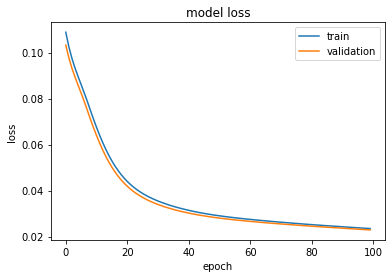

In [65]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## DNN!